# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


# Membres du Groupe :

1.   ZAFIARISON Koloina Emile, IGGLIA 4, n°10
2.   RASAMOELINA Toky Sandratra Miharimamy, IGGLIA 4 , n°07
3.   RANDRIANOELINA Liantsoa Harimisa IGGLIA4, n°15
4.   RASOLONJATOVO Zo Heriniaina, IGGLIA 4, n°24
5.   RANDIMBINIRINA RAKOTOMANANA Yusha Andry Ny Aina, IGGLIA 4, n°45

# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

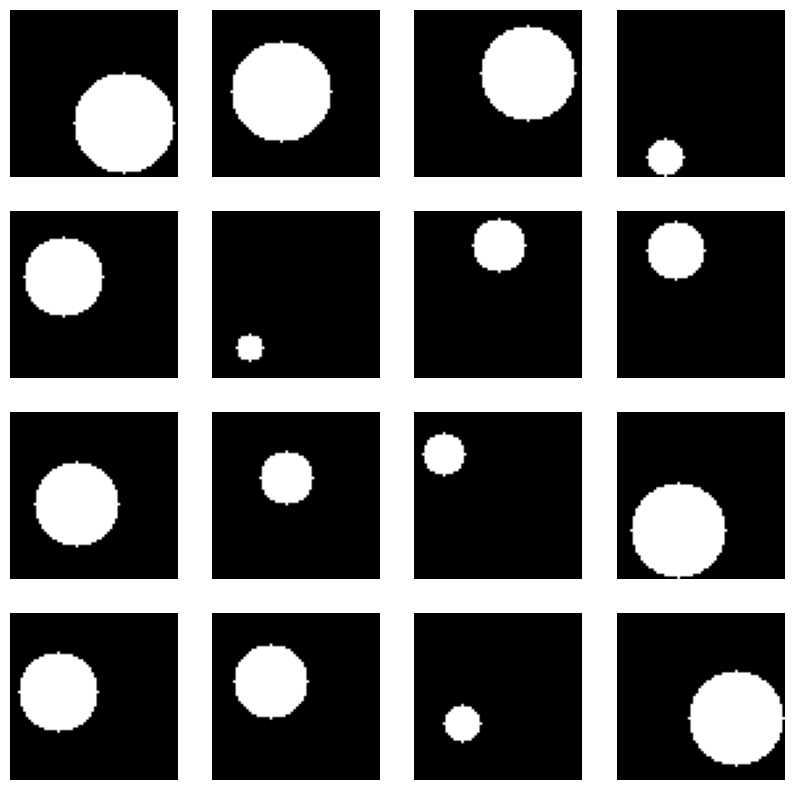

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def generate_dataset(n_samples=10000, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset
data = generate_dataset(n_samples=10000, image_size=64)

# Afficher quelques exemples
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [51]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)


Entraînement: (8000, 64, 64, 1)
Test: (2000, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [52]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)

autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_fc.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053,699 (4.02 MB)

 Trainable params: 1,053,699 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [53]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.4670 - val_loss: 0.1558
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1416 - val_loss: 0.1093
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1020 - val_loss: 0.0885
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0858 - val_loss: 0.0805
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0798 - val_loss: 0.0751
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0744 - val_loss: 0.0730
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0721 - val_loss: 0.0713
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0707 - val_loss: 0.0691
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0689 - val_loss: 0.0671
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0664 - val_loss: 0.0663
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0651 - val_loss: 0.0638
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0622 - val_l

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


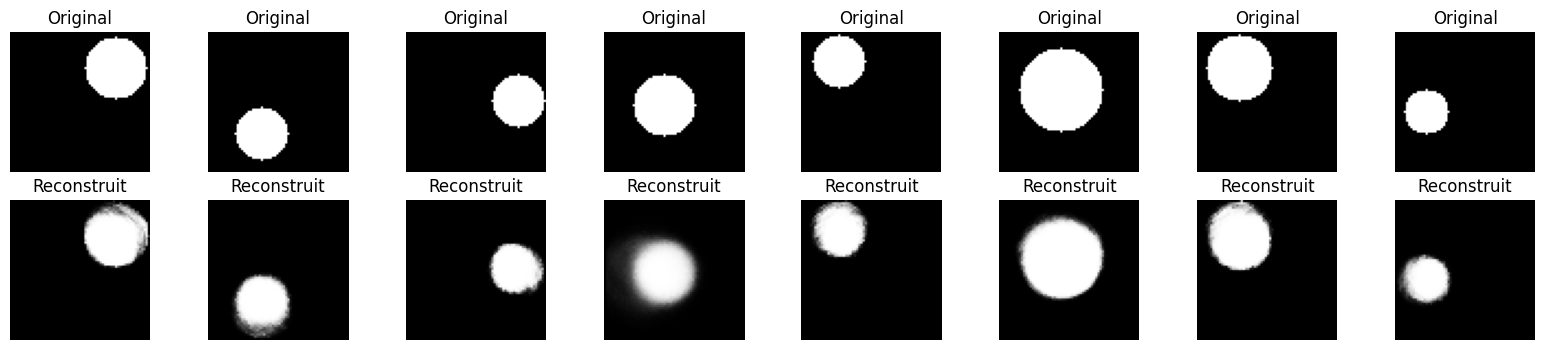

In [54]:
decoded_imgs_fc = autoencoder_fc.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [55]:
input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv = models.Model(input_img, decoded)

autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          49,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16384)               │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 32, 32, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 64, 64, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,188 (739.02 KB)

 Trainable params: 189,188 (739.02 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [56]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.5163 - val_loss: 0.3107
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2806 - val_loss: 0.1758
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1607 - val_loss: 0.1087
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0974 - val_loss: 0.0819
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0765 - val_loss: 0.0642
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0608 - val_loss: 0.0502
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0465 - val_loss: 0.0379
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0369 - val_loss: 0.0361
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0316 - val_loss: 0.0277
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0290 - val_loss: 0.0250
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0271 - val_loss: 0.0247
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


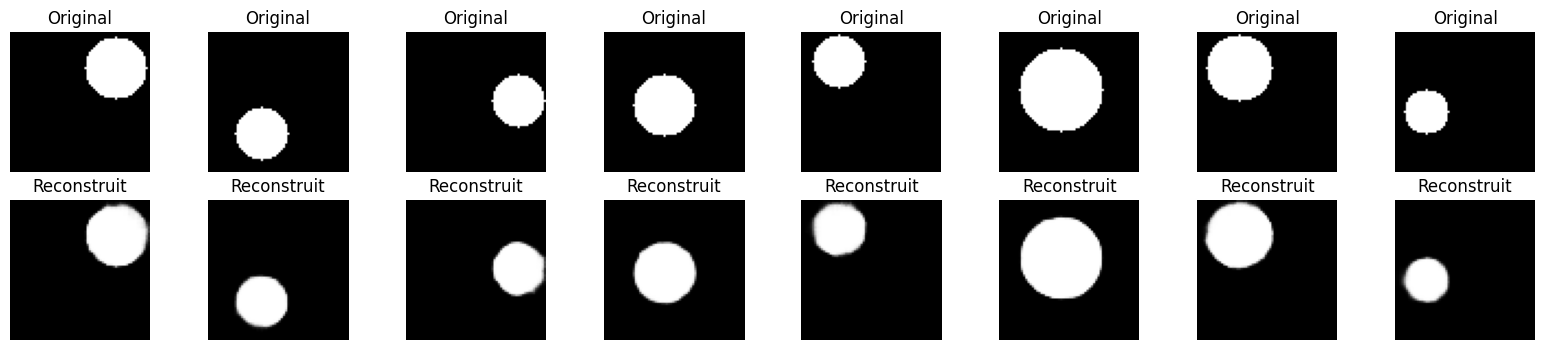

In [57]:
decoded_imgs_conv = autoencoder_conv.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.



---


---



---




#**Question 1 :** Teste des deux modèles sur des images d'entrées imparfaites et interprétation

In [58]:
def salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    """Ajoute du bruit salt and pepper à une image."""
    noisy_image = np.copy(image)
    total_pixels = image.size

    # Ajouter du bruit "sel" (blanc)
    num_salt = int(salt_prob * total_pixels)
    salt_coords = [np.random.randint(0, i-1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 1

    # Ajouter du bruit "poivre" (noir)
    num_pepper = int(pepper_prob * total_pixels)
    pepper_coords = [np.random.randint(0, i-1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image


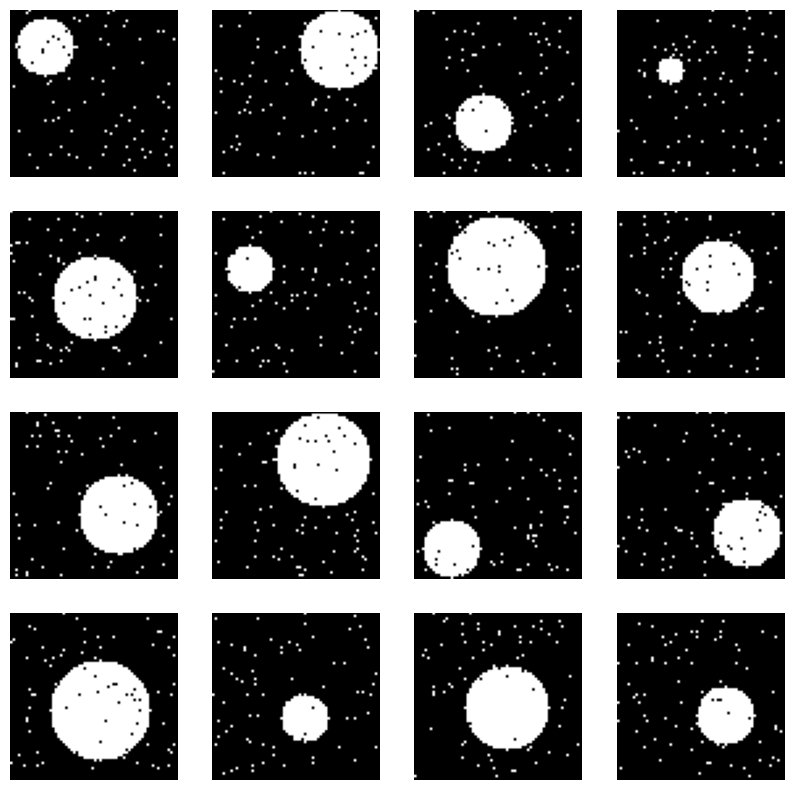

In [59]:
def add_noise_to_dataset(dataset, noise_func=salt_and_pepper_noise, **kwargs):
    noisy_dataset = []
    for img in dataset:
        noisy_img = noise_func(img.squeeze(), **kwargs)  # Retirer la dimension de canal pour l'application du bruit
        noisy_dataset.append(noisy_img)
    return np.expand_dims(np.array(noisy_dataset), axis=-1)  # Ajouter la dimension du canal

# Ajouter du bruit salt and pepper aux données
train_data_noisy = add_noise_to_dataset(train_data, salt_and_pepper_noise, salt_prob=0.02, pepper_prob=0.02)
test_data_noisy = add_noise_to_dataset(test_data, salt_and_pepper_noise, salt_prob=0.02, pepper_prob=0.02)

# Afficher des exemples avec et sans bruit
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_data_noisy[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


**Entraînement sur les données bruitées avec le modèle FC**

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2762 - val_loss: 0.2220
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2046 - val_loss: 0.1732
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1671 - val_loss: 0.1605
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1567 - val_loss: 0.1553
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1520 - val_loss: 0.1525
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1494 - val_loss: 0.1505
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1473 - val_loss: 0.1489
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1455 - val_loss: 0.1479
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1446 - val_loss: 0.1470
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1434 - val_loss: 0.1463
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1426 - val_loss: 0.1456
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1420 - val_lo

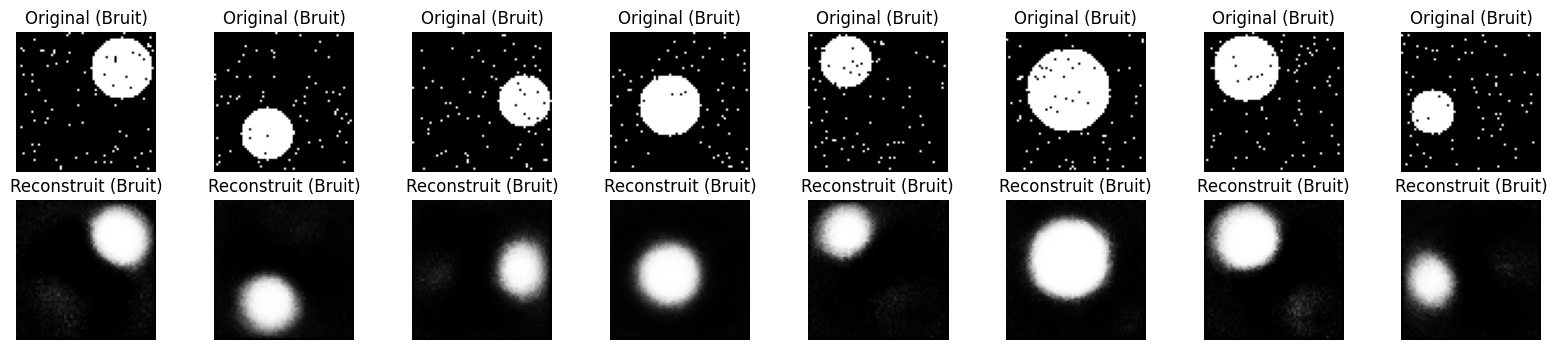

In [60]:
# Entraînement sur les données bruitées
history_fc_noisy = autoencoder_fc.fit(train_data_noisy, train_data_noisy,
                                      epochs=20,
                                      batch_size=128,
                                      shuffle=True,
                                      validation_data=(test_data_noisy, test_data_noisy))

# Reconstructions avec le modèle Dense
decoded_imgs_fc_noisy = autoencoder_fc.predict(test_data_noisy)

# Visualisation des reconstructions (Bruit + FC)
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data_noisy[i].squeeze(), cmap='gray')
    plt.title('Original (Bruit)')
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc_noisy[i].squeeze(), cmap='gray')
    plt.title('Reconstruit (Bruit)')
    plt.axis('off')
plt.show()


**Entraînement sur les données bruitées avec le modèle Convolutionnel**

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.5984 - val_loss: 0.1589
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1535 - val_loss: 0.1430
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1402 - val_loss: 0.1337
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1323 - val_loss: 0.1277
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1265 - val_loss: 0.1234
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1225 - val_loss: 0.1205
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1196 - val_loss: 0.1181
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1174 - val_loss: 0.1163
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1154 - val_loss: 0.1147
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1140 - val_loss: 0.1134
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1127 - val_loss: 0.1126
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1

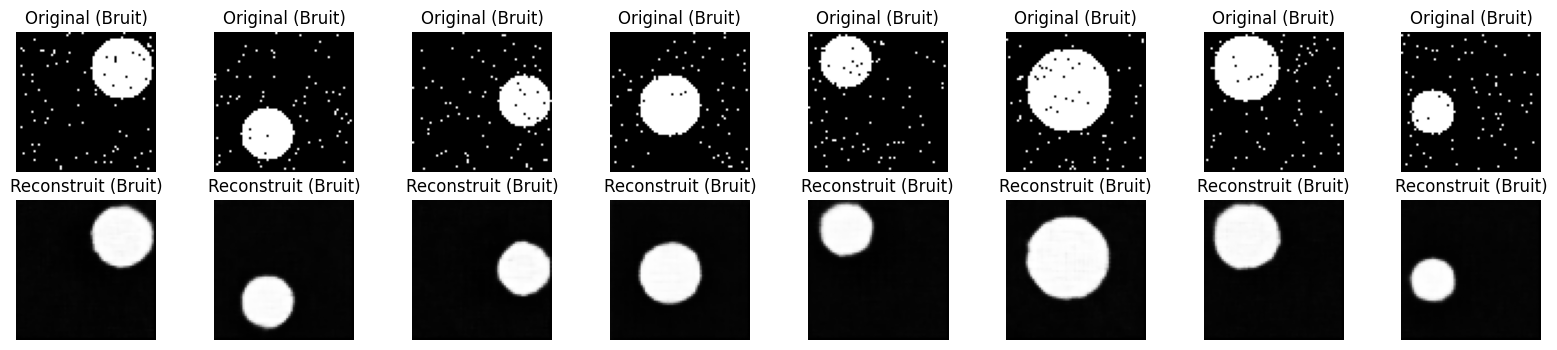

In [61]:
# Entraînement sur les données bruitées
history_conv_noisy = autoencoder_conv.fit(train_data_noisy, train_data_noisy,
                                          epochs=20,
                                          batch_size=128,
                                          shuffle=True,
                                          validation_data=(test_data_noisy, test_data_noisy))

# Reconstructions avec le modèle Convolutionnel
decoded_imgs_conv_noisy = autoencoder_conv.predict(test_data_noisy)

# Visualisation des reconstructions (Bruit + Convolutionnel)
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data_noisy[i].squeeze(), cmap='gray')
    plt.title('Original (Bruit)')
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv_noisy[i].squeeze(), cmap='gray')
    plt.title('Reconstruit (Bruit)')
    plt.axis('off')
plt.show()


##Interpretation
On constate que l'autoencodeur convolutionnel est généralement plus performant pour gérer les imperfections spaciales (bruit et masquage), tandis que l'autoencodeur FC produit des résultats plus lisses mais moins précis.


Comparaison des deux modèles :

1. Calcul de l'erreur de reconstruction

In [62]:
from sklearn.metrics import mean_squared_error

# Fonction pour calculer l'erreur MSE de reconstruction
def calculate_mse(original, reconstructed):
    return mean_squared_error(original.flatten(), reconstructed.flatten())

# Calcul des erreurs de reconstruction pour les deux modèles
mse_fc = calculate_mse(test_data, decoded_imgs_fc_noisy)
mse_conv = calculate_mse(test_data, decoded_imgs_conv_noisy)

print(f"Erreur de reconstruction (MSE) pour l'autoencodeur Fully Connected : {mse_fc}")
print(f"Erreur de reconstruction (MSE) pour l'autoencodeur Convolutionnel : {mse_conv}")


Erreur de reconstruction (MSE) pour l'autoencodeur Fully Connected : 0.01412944681942463
Erreur de reconstruction (MSE) pour l'autoencodeur Convolutionnel : 0.004843434318900108


2. Visualisation des courbes de perte pendant l'entraînement.

Nous allons tracer les courbes de perte pour les deux modèles (loss vs epochs), pour voir lequel converge plus rapidement et atteint un meilleur minimum.

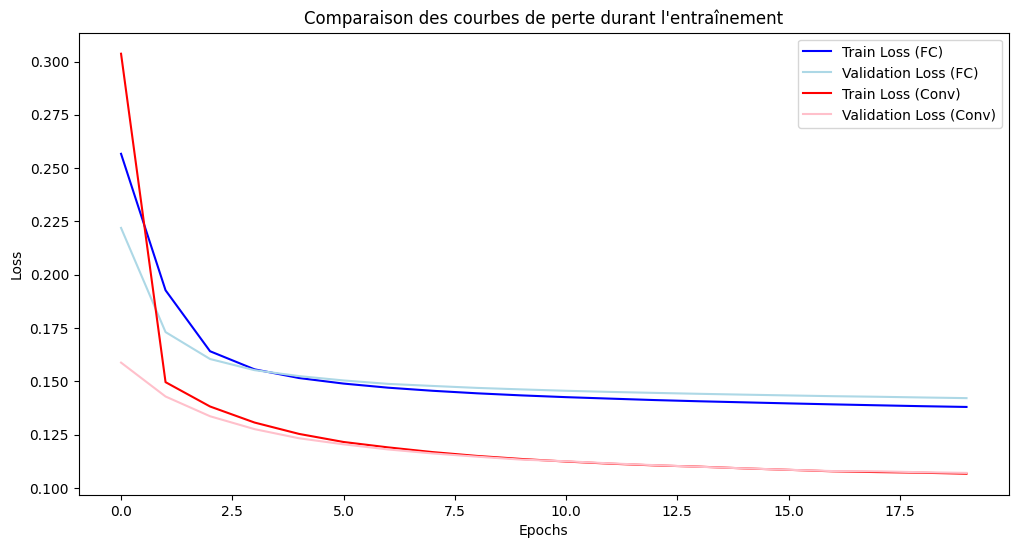

In [63]:
# Récupérer l'historique des pertes pour chaque modèle
history_fc_loss = history_fc_noisy.history['loss']
history_fc_val_loss = history_fc_noisy.history['val_loss']

history_conv_loss = history_conv_noisy.history['loss']
history_conv_val_loss = history_conv_noisy.history['val_loss']

# Tracer les courbes de perte
plt.figure(figsize=(12, 6))

# Courbes de perte pour l'autoencodeur Fully Connected
plt.plot(history_fc_loss, label='Train Loss (FC)', color='blue')
plt.plot(history_fc_val_loss, label='Validation Loss (FC)', color='lightblue')

# Courbes de perte pour l'autoencodeur Convolutionnel
plt.plot(history_conv_loss, label='Train Loss (Conv)', color='red')
plt.plot(history_conv_val_loss, label='Validation Loss (Conv)', color='pink')

plt.title("Comparaison des courbes de perte durant l'entraînement")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


3. Visualisation de la comparaison des erreurs de reconstruction

Nous allons maintenant ajouter un graphique pour comparer les erreurs de reconstruction (MSE) entre les deux modèles.

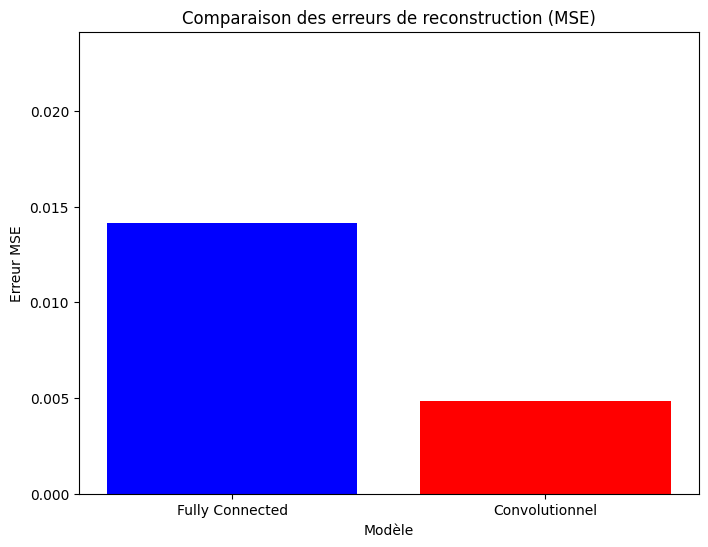

In [64]:
# Comparaison des erreurs MSE
models = ['Fully Connected', 'Convolutionnel']
errors = [mse_fc, mse_conv]

plt.figure(figsize=(8, 6))
plt.bar(models, errors, color=['blue', 'red'])
plt.title('Comparaison des erreurs de reconstruction (MSE)')
plt.xlabel('Modèle')
plt.ylabel('Erreur MSE')
plt.ylim([0, max(errors) + 0.01])
plt.show()


Courbes de perte pendant l'entraînement : Si la courbe de perte de l'autoencodeur convolutionnel descend plus rapidement et atteint une valeur plus basse que celle de l'autoencodeur entièrement connecté, cela indique que le modèle convolutionnel est plus performant pour apprendre les motifs et la structure des images bruitées.

Erreur de reconstruction (MSE) : Si l'erreur MSE de l'autoencodeur convolutionnel est plus faible que celle du modèle entièrement connecté, cela suggère que le modèle convolutionnel est mieux à même de débruiter les images et de les reconstruire fidèlement. Ce résultat est attendu, car les modèles convolutionnels sont spécialement conçus pour capturer des relations spatiales locales, ce qui leur permet de mieux gérer le bruit "salt and pepper".

**Afficher le F1-score et l'AUC**

In [65]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# Fonction pour calculer le F1-score et l'AUC entre les images originales et reconstruites
def calculate_metrics(original, reconstructed):
    """Calculer le F1-score et l'AUC entre l'image originale et reconstruite"""
    reconstructed = (reconstructed > 0.5).astype(int)  # Binarisation pour le calcul des métriques
    f1 = f1_score(original.flatten(), reconstructed.flatten(), average='micro')
    auc = roc_auc_score(original.flatten(), reconstructed.flatten())
    return f1, auc

# 1. Autoencodeur Fully Connected (FC)
decoded_imgs_fc_noisy = autoencoder_fc.predict(test_data_noisy)
f1_fc, auc_fc = calculate_metrics(test_data, decoded_imgs_fc_noisy)

# 2. Autoencodeur Convolutionnel
decoded_imgs_conv_noisy = autoencoder_conv.predict(test_data_noisy)
f1_conv, auc_conv = calculate_metrics(test_data, decoded_imgs_conv_noisy)

# Affichage des résultats
print(f"Autoencodeur Fully Connected (FC) - F1-score: {f1_fc:.4f}, AUC: {auc_fc:.4f}")
print(f"Autoencodeur Convolutionnel - F1-score: {f1_conv:.4f}, AUC: {auc_conv:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Autoencodeur Fully Connected (FC) - F1-score: 0.9860, AUC: 0.9598
Autoencodeur Convolutionnel - F1-score: 0.9943, AUC: 0.9881


#**Question 2 :** Amélioration du modèle convolutionnel

Amélioration de l'encodeur


*   Ajout de Batch Normalization après chaque couche Conv2D pour stabiliser l’apprentissage et accélèrer la convergence.
*   Ajout d’une couche Conv2D(128) pour augmenter la capacité d'extraction des caractéristiques.
*   Augmentation progressive du nombre de filtres (32 → 64 →   128) afin de capturer des caractéristiques plus complexes.

In [66]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.BatchNormalization()(x)  # Ajout de BatchNorm
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)  # Nouvelle couche
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)  # On garde 3 dimensions


Amélioration du décodeur



*  Ajout d’une couche Dense plus grande (8×8×128) por fournir    plus d’informations dès la reconstruction.
*   Ajout de Conv2D après chaque Conv2DTranspose afin d'affiner les détails des images reconstruites.
*   Ajout de Batch Normalization pour améliorer la stabilité et réduire l'overfitting.

In [67]:

# Décodeur
x = layers.Dense(8*8*128, activation='relu')(latent)  # Plus de neurones pour aider à reconstruire
x = layers.Reshape((8,8,128))(x)

x = layers.Conv2DTranspose(128, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)  # Raffinement
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)

decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)



**Compilation du modèle**

In [68]:
# Compilation du modèle
autoencoder_conv = models.Model(input_img, decoded)
autoencoder_conv.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
autoencoder_conv.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          24,579 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 8192)                │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 16, 16, 128)         │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (None, 32, 32, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 585,700 (2.23 MB)

 Trainable params: 584,804 (2.23 MB)

 Non-trainable params: 896 (3.50 KB)

**Entraînement du nouveau modèle**

*  Changement de la fonction de perte (binary_crossentropy en MSE) pour minimiser les pertes d’information sur les images en niveaux de gris.

*  Ajout de ReduceLROnPlateau pour diminuer automatiquement le taux d’apprentissage si le modèle ne s’améliore plus, ce qui l’aide à mieux apprendre sur la fin

In [73]:
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Préparation des données
train_data_noisy = np.array(train_data_noisy).reshape(-1, 64, 64, 1)
test_data_noisy = np.array(test_data_noisy).reshape(-1, 64, 64, 1)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

autoencoder_conv.compile(optimizer='adam', loss='mse')  # Changement de perte

history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20, batch_size=500,
                                  shuffle=True,
                                  validation_data=(test_data, test_data),
                                  callbacks=callbacks)


# Reconstructions avec le modèle Convolutionnel
decoded_imgs_conv_noisy = autoencoder_conv.predict(test_data_noisy)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - loss: 0.0297 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - loss: 0.0151 - val_loss: 0.1178 - learning_rate: 0.0010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - loss: 0.0101 - val_loss: 0.1209 - learning_rate: 0.0010
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - loss: 0.0088 - val_loss: 0.1218 - learning_rate: 0.0010
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - loss: 0.0077 - val_loss: 0.1231 - learning_rate: 0.0010
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - loss: 0.0069 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - loss: 0.0063 - val_loss: 0.1184 - learning_rate: 5.0000e-04
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - loss: 0.0053 - val_loss: 0.1197 - learning_rate: 5.0000e-04
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - loss: 0.0055 - val_loss: 0.1133 - learning_rate: 5.0000e-

Résultat en utilisant le modèle déjà amélioré

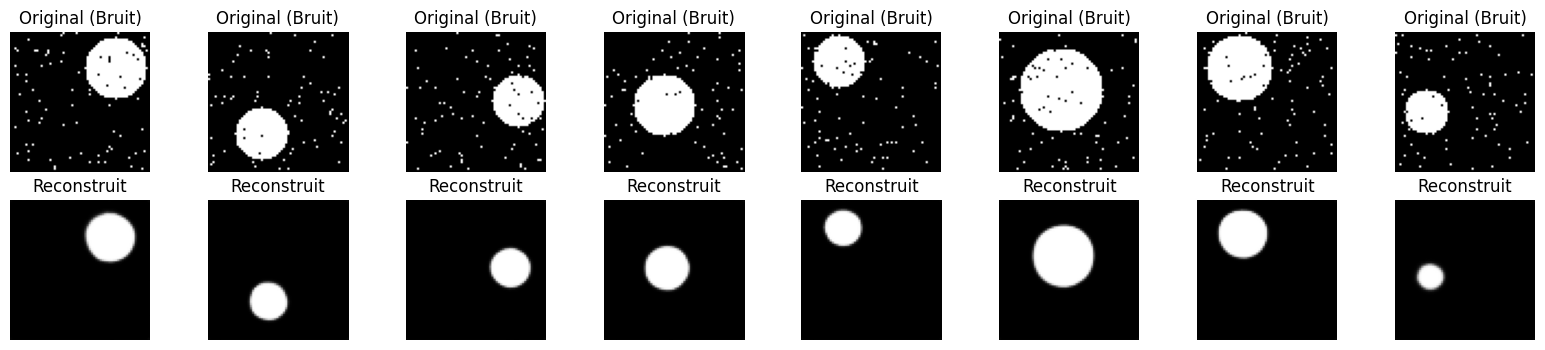

In [74]:

# Visualisation des reconstructions (Bruit + Convolutionnel)
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data_noisy[i].squeeze(), cmap='gray')
    plt.title('Original (Bruit)')
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv_noisy[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()




---



#**Question 3 :** Analyse de la dimension de l'espace latent

Non, il n'est pas nécessaire d'augmenter la taille de l'espace latent (actuellement de dimension 3) pour cette tâche spécifique. Voici les arguments qui soutiennent cette position :

1. **Justification théorique :**
   - Un cercle est mathématiquement défini par exactement 3 paramètres :
     * Les coordonnées (x,y) du centre
     * Le rayon r
   - Ces 3 paramètres sont suffisants pour reconstruire n'importe quel cercle dans notre espace d'images
   - Toute dimension supplémentaire serait redondante

2. **Résultats empiriques :**
   - Les reconstructions obtenues avec l'espace latent de dimension 3 sont déjà de très bonne qualité
   - Les cercles reconstruits conservent :
     * Leur position (centre)
     * Leur taille (rayon)
     * Leur forme circulaire
   - Les contours sont nets et bien définis

3. **Principe de parcimonie :**
   - Augmenter la dimension de l'espace latent :
     * Augmenterait la complexité du modèle
     * Nécessiterait plus de paramètres à entraîner
     * Risquerait de conduire à du surapprentissage
   - Le principe du rasoir d'Occam suggère de choisir le modèle le plus simple capable de résoudre le problème

4. **Comparaison des architectures :**
   - Les deux architectures (FCN et CNN) parviennent à de bons résultats avec 3 dimensions
   - Même avec du bruit ou des parties masquées, les modèles reconstruisent correctement les cercles
   - Cela suggère que 3 dimensions capturent effectivement toute l'information nécessaire

En conclusion, la dimension 3 de l'espace latent est optimale pour cette tâche car elle correspond exactement au nombre de degrés de liberté du problème. Une augmentation de cette dimension n'apporte